## Overview

In this notebook, data cleaning, preprocessng and exploratory analysis were carried out on the previously downloaded subreddit posts from r/tea and r/Coffee. 

The following steps were taken:

**Data cleaning**: 
* Imputed nulls with empty spaces
* Removal of duplicate rows (2 rounds), web addresses, punctuation, numbers 
* Changed words to all lowercase

**Exploratory data analysis**:
* Examined word count on title and self text
* Derived top 15 single words, bigrams and trigrams (before lemmatizing and stopword removal)

**Preprocessing** :
* Combined title and self text into a new column
* Stopword removal
* Lemmatizing
* Tokenisation
* Dummify target variable ('subreddit' column)

**Results**:

* From the total of 5943 rows and 109 (r/Coffee) /118 (r/tea) columns of data, the final merged dataframe had 1578 rows and 18 columns. 
* The cleaned dataframes for tea and coffee were merged and exported as a csv file to be used in the next notebook on modeling. 

## Import Python modules

In [228]:
import requests 
import pandas as pd
import numpy as np
import time
import string
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
#import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

## Import earlier scraped subreddit posts

In [690]:
#import csvs of earlier scraped posts

df_tea = pd.read_csv('data/tea.csv')
df_coffee = pd.read_csv('data/coffee.csv')

print(f'Shape of df_tea: {df_tea.shape}') #(2958, 118) 
print(f'Shape of df_coffee: {df_coffee.shape}') #(2985, 109) 

Shape of df_tea: (2958, 118)
Shape of df_coffee: (2985, 109)


In [691]:
#check results of importing
df_tea.head(3) #tea dataframe

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,url_overridden_by_dest,preview,is_gallery,media_metadata,gallery_data,crosspost_parent_list,crosspost_parent,call_to_action,poll_data,author_cakeday
0,NaN,tea,"What are you drinking today? What questions have been on your mind? Any stories to share? And don't worry, no one will make fun of you for what you drink or the questions you ask. \n\nYou can also talk about anything else on your mind, from your specific routine while making tea, or how you've been on an oolong kick lately. Feel free to link to pictures in here, as well. You can even talk ...",t2_6l4z3,False,NaN,0,False,"What's in your cup? Daily discussion, questions and stories - May 23, 2022","[{'e': 'text', 't': 'Recurring'}]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,tea,"We realize there are lots of people involved in the tea industry here, so this thread is a weekly feature where anyone can promote their current projects without worrying about the self-promotion rules. Feel free to include links to your shop, crowdfunding sites, surveys, sales, or discount codes. The rule against claims of health benefits remains in effect here. It should go without saying...",t2_6l4z3,False,NaN,0,False,"Marketing Monday! - May 23, 2022","[{'e': 'text', 't': 'Recurring'}]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,tea,NaN,t2_3jjsa,False,NaN,0,False,I’m in London. I like tea. (Thank you for the recommendations),"[{'e': 'text', 't': 'Photo'}]",...,https://i.imgur.com/PcuYX6j.jpg,"{'images': [{'source': {'url': 'https://external-preview.redd.it/BmXPNeAJwl8Nyljhbeicqms8GXjsQohmNcAG3NWayGE.jpg?auto=webp&amp;s=4700af7b6b5ffc5ce7f1ce48263935965c4fcac2', 'width': 4032, 'height': 3024}, 'resolutions': [{'url': 'https://external-preview.redd.it/BmXPNeAJwl8Nyljhbeicqms8GXjsQohmNcAG3NWayGE.jpg?width=108&amp;crop=smart&amp;auto=webp&amp;s=533b50a166421fc2c3bce0e6f59bbd10afeb0e19'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [692]:
#coffee dataframe
df_coffee.head(3)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,subreddit_subscribers,created_utc,num_crossposts,media,is_video,media_metadata,call_to_action,url_overridden_by_dest,is_gallery,gallery_data
0,NaN,Coffee,"\n\nWelcome to the daily [/r/Coffee](https://www.reddit.com/r/Coffee) question thread!\n\nThere are no stupid questions here, ask a question and get an answer! We all have to start somewhere and sometimes it is hard to figure out just what you are doing right or doing wrong. Luckily, the [/r/Coffee](https://www.reddit.com/r/Coffee) community loves to help out.\n\nDo you have a question about ...",t2_a04m4,False,NaN,0,False,[MOD] The Daily Question Thread,[],...,999603,1.653300e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
1,NaN,Coffee,"Welcome to the /r/Coffee deal and promotional thread! In this weekly thread, industry folk can post upcoming deals or other promotions their companies are holding, or promote new products to /r/Coffee subscribers! Regular users can also post deals they come across. Come check out some of the roasters and other coffee-related businesses that Redditors work for!\n\nNote that this thread will be ...",t2_a04m4,False,NaN,0,False,[MOD] The Official Deal Thread,[],...,999603,1.653261e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
2,NaN,Coffee,"Went to make my annual summer toddy filter purchase today and noticed a few metal options I hadn't seen before, but looked suspiciously like the reusable steel filters for the Aeropress. On a whim, I went into my kitchen and boom: almost a perfect fit. I'll probably double-filter this batch through a french press or something, but should be more than enough to keep the majority of the grinds o...",t2_6qnov,False,NaN,0,False,TIL: The diameters of the Aeropress and Toddy Cold Brew bucket filters are almost exactly the same.,[],...,999603,1.653337e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN


## Select relevant columns

In [693]:
tea = df_tea[['subreddit', 'title', 'selftext']]
coffee = df_coffee[['subreddit', 'title', 'selftext']]

## Examine null values in each column

In [694]:
print(f" Proportion of nulls in tea: {tea.isnull().mean()[tea.isnull().mean()>0]}\n") 
print(f" Proportion of nulls in coffee: {coffee.isnull().mean()[coffee.isnull().mean()>0]}")

 Proportion of nulls in tea: selftext    0.537525
dtype: float64

 Proportion of nulls in coffee: selftext    0.01876
dtype: float64


There are about 53% null values for self text in 'tea', and about 19% null values for self text in 'coffee'.

## Impute nulls with empty space

In [695]:
tea.fillna(" ", inplace = True)
coffee.fillna(" ", inplace = True)

print(f'Nulls left for tea: {tea.isnull().mean().sum()}') #no nulls left
print(f'Nulls left for coffee: {coffee.isnull().mean().sum()}') #no nulls left

Nulls left for tea: 0.0
Nulls left for coffee: 0.0


C:\Users\yongl\anaconda3\lib\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


## Create a new column 'alltext'

In [696]:
#create new column for tea
tea['alltext'] = tea['title'].astype(str) + " " + tea['selftext'].astype(str)
#create new column for coffee
coffee['alltext'] = coffee['title'].astype(str) + " " + coffee['selftext'].astype(str)

C:\Users\yongl\AppData\Local\Temp/ipykernel_34828/1049417101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tea['alltext'] = tea['title'].astype(str) + " " + tea['selftext'].astype(str)
C:\Users\yongl\AppData\Local\Temp/ipykernel_34828/1049417101.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coffee['alltext'] = coffee['title'].astype(str) + " " + coffee['selftext'].astype(str)


In [697]:
#checking new alltext column - tea
tea['alltext'].head()

0    What's in your cup? Daily discussion, questions and stories - May 23, 2022 What are you drinking today?  What questions have been on your mind?  Any stories to share?  And don't worry, no one will make fun of you for what you drink or the questions you ask. \n\nYou can also talk about anything else on your mind, from your specific routine while making tea, or how you've been on an oolong kick ...
1    Marketing Monday! - May 23, 2022 We realize there are lots of people involved in the tea industry here, so this thread is a weekly feature where anyone can promote their current projects without worrying about the self-promotion rules.  Feel free to include links to your shop, crowdfunding sites, surveys, sales, or discount codes.  The rule against claims of health benefits remains in effect h...
2                                                                                                                                                                                             

In [698]:
#checking new alltext column - coffee
coffee['alltext'].head()

0    [MOD] The Daily Question Thread  \n\nWelcome to the daily [/r/Coffee](https://www.reddit.com/r/Coffee) question thread!\n\nThere are no stupid questions here, ask a question and get an answer! We all have to start somewhere and sometimes it is hard to figure out just what you are doing right or doing wrong. Luckily, the [/r/Coffee](https://www.reddit.com/r/Coffee) community loves to help out.\...
1    [MOD] The Official Deal Thread Welcome to the /r/Coffee deal and promotional thread! In this weekly thread, industry folk can post upcoming deals or other promotions their companies are holding, or promote new products to /r/Coffee subscribers! Regular users can also post deals they come across. Come check out some of the roasters and other coffee-related businesses that Redditors work for!\n\...
2    TIL: The diameters of the Aeropress and Toddy Cold Brew bucket filters are almost exactly the same. Went to make my annual summer toddy filter purchase today and noticed a few metal opt

## Remove duplicates, web addresses, punctuation, numbers and change to lowercase

We will first search and remove duplicate rows using the `alltext` column. Followed by web addresses inside `selftext` and `alltext`, followed by punctuations and numbers in all columns. Order of operation is important, as removing punctuations and numbers first will break up the web address string.

#### Create cleaning functions

In [699]:
#define list of columns to be used in functions
original_cols = ['title', 'selftext', 'alltext']
cleaned_cols = [str(col) + '_cleaned' for col in original_cols]

#create function to remove duplicates using alltext column #works
def remove_duplicates(df):
    df.drop_duplicates(subset=['alltext'], inplace = True)
    return df

#create function to replace web addresses with " "  #works
def remove_web(df):
    for col in original_cols:
        cleaned_col = str(col) + '_cleaned'
        df[cleaned_col] = df[col].str.replace(r'http\S+|https\S+|www.\S+',' ')
    return df  

#create function to replace punctuations with " " #works
def remove_punct(df):
    pattern = r"[{}]".format(string.punctuation)
    for col in cleaned_cols:
        df[col] = df[col].str.replace(pattern, ' ')
    return df

#create function to replace numbers with " " #works
def remove_num(df):
    for col in cleaned_cols:
        df[col] = df[col].str.replace(r'\d', ' ', regex = True)
    return df

#create function to convert all words to lower case
def to_lower(df):
    for col in cleaned_cols:
        df[col] = df[col].str.lower()
    return df

#consolidate all cleaning processes in one function
def cleaning(df):
    
    remove_duplicates(df)
    remove_web(df)
    remove_punct(df)
    remove_num(df)
    to_lower(df)
    
    return df

In [700]:
#carrying out cleaning on tea and coffee dataframes
cleaning(tea)
cleaning(coffee)

C:\Users\yongl\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\yongl\AppData\Local\Temp/ipykernel_34828/2295051407.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df[cleaned_col] = df[col].str.replace(r'http\S+|https\S+|www.\S+',' ')
C:\Users\yongl\AppData\Local\Temp/ipykernel_34828/2295051407.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cleaned_col] = df[col].str.replace(r'http\S+|https\S+|www.\S+',' ')

,subreddit,title,selftext,alltext,title_cleaned,selftext_cleaned,alltext_cleaned
0,Coffee,[MOD] The Daily Question Thread,"\n\nWelcome to the daily [/r/Coffee](https://www.reddit.com/r/Coffee) question thread!\n\nThere are no stupid questions here, ask a question and get an answer! We all have to start somewhere and sometimes it is hard to figure out just what you are doing right or doing wrong. Luckily, the [/r/Coffee](https://www.reddit.com/r/Coffee) community loves to help out.\n\nDo you have a question about ...","[MOD] The Daily Question Thread \n\nWelcome to the daily [/r/Coffee](https://www.reddit.com/r/Coffee) question thread!\n\nThere are no stupid questions here, ask a question and get an answer! We all have to start somewhere and sometimes it is hard to figure out just what you are doing right or doing wrong. Luckily, the [/r/Coffee](https://www.reddit.com/r/Coffee) community loves to help out.\...",mod the daily question thread,\n\nwelcome to the daily r coffee question thread \n\nthere are no stupid questions here ask a question and get an answer we all have to start somewhere and sometimes it is hard to figure out just what you are doing right or doing wrong luckily the r coffee community loves to help out \n\ndo you have a question about how to use a specific piece of gear or what gear you should be...,mod the daily question thread \n\nwelcome to the daily r coffee question thread \n\nthere are no stupid questions here ask a question and get an answer we all have to start somewhere and sometimes it is hard to figure out just what you are doing right or doing wrong luckily the r coffee community loves to help out \n\ndo you have a question about how to use a specific piece of...
1,Coffee,[MOD] The Official Deal Thread,"Welcome to the /r/Coffee deal and promotional thread! In this weekly thread, industry folk can post upcoming deals or other promotions their companies are holding, or promote new products to /r/Coffee subscribers! Regular users can also post deals they come across. Come check out some of the roasters and other coffee-related businesses that Redditors work for!\n\nNote that this thread will be ...","[MOD] The Official Deal Thread Welcome to the /r/Coffee deal and promotional thread! In this weekly thread, industry folk can post upcoming deals or other promotions their companies are holding, or promote new products to /r/Coffee subscribers! Regular users can also post deals they come across. Come check out some of the roasters and other coffee-related businesses that Redditors work for!\n\...",mod the official deal thread,welcome to the r coffee deal and promotional thread in this weekly thread industry folk can post upcoming deals or other promotions their companies are holding or promote new products to r coffee subscribers regular users can also post deals they come across come check out some of the roasters and other coffee related businesses that redditors work for \n\nnote that this thread will be ...,mod the official deal thread welcome to the r coffee deal and promotional thread in this weekly thread industry folk can post upcoming deals or other promotions their companies are holding or promote new products to r coffee subscribers regular users can also post deals they come across come check out some of the roasters and other coffee related businesses that redditors work for \n\...
2,Coffee,TIL: The diameters of the Aeropress and Toddy Cold Brew bucket filters are almost exactly the same.,"Went to make my annual summer toddy filter purchase today and noticed a few metal options I hadn't seen before, but looked suspiciously like the reusable steel filters for the Aeropress. On a whim, I went into my kitchen and boom: almost a perfect fit. I'll probably double-filter this batch through a french press or something, but should be more than enough to keep the majority of the grinds o...","TIL: The diameters of the Aeropress and Toddy Cold Brew bucket filters are almost exactly the same. Went to m

#### Checking cleaning results

In [701]:
#check shape of dataframes after cleaning
print(f'Shape of tea dataframe: {tea.shape}') #(985, 7)
print(f'Shape of coffee dataframe: {coffee.shape}') #(630, 7)

Shape of tea dataframe: (985, 7)
Shape of coffee dataframe: (630, 7)


In [702]:
#checking cleaning results
tea[['title_cleaned', 'selftext_cleaned', 'alltext_cleaned']].head(3)

,title_cleaned,selftext_cleaned,alltext_cleaned
0,what s in your cup daily discussion questions and stories may,what are you drinking today what questions have been on your mind any stories to share and don t worry no one will make fun of you for what you drink or the questions you ask \n\nyou can also talk about anything else on your mind from your specific routine while making tea or how you ve been on an oolong kick lately feel free to link to pictures in here as well you can even talk ...,what s in your cup daily discussion questions and stories may what are you drinking today what questions have been on your mind any stories to share and don t worry no one will make fun of you for what you drink or the questions you ask \n\nyou can also talk about anything else on your mind from your specific routine while making tea or how you ve been on an oolong kick ...
1,marketing monday may,we realize there are lots of people involved in the tea industry here so this thread is a weekly feature where anyone can promote their current projects without worrying about the self promotion rules feel free to include links to your shop crowdfunding sites surveys sales or discount codes the rule against claims of health benefits remains in effect here it should go without saying...,marketing monday may we realize there are lots of people involved in the tea industry here so this thread is a weekly feature where anyone can promote their current projects without worrying about the self promotion rules feel free to include links to your shop crowdfunding sites surveys sales or discount codes the rule against claims of health benefits remains in effect h...
2,i’m in london i like tea thank you for the recommendations,,i’m in london i like tea thank you for the recommendations


In [703]:
coffee[['title_cleaned', 'selftext_cleaned', 'alltext_cleaned']].head(3)

,title_cleaned,selftext_cleaned,alltext_cleaned
0,mod the daily question thread,\n\nwelcome to the daily r coffee question thread \n\nthere are no stupid questions here ask a question and get an answer we all have to start somewhere and sometimes it is hard to figure out just what you are doing right or doing wrong luckily the r coffee community loves to help out \n\ndo you have a question about how to use a specific piece of gear or what gear you should be...,mod the daily question thread \n\nwelcome to the daily r coffee question thread \n\nthere are no stupid questions here ask a question and get an answer we all have to start somewhere and sometimes it is hard to figure out just what you are doing right or doing wrong luckily the r coffee community loves to help out \n\ndo you have a question about how to use a specific piece of...
1,mod the official deal thread,welcome to the r coffee deal and promotional thread in this weekly thread industry folk can post upcoming deals or other promotions their companies are holding or promote new products to r coffee subscribers regular users can also post deals they come across come check out some of the roasters and other coffee related businesses that redditors work for \n\nnote that this thread will be ...,mod the official deal thread welcome to the r coffee deal and promotional thread in this weekly thread industry folk can post upcoming deals or other promotions their companies are holding or promote new products to r coffee subscribers regular users can also post deals they come across come check out some of the roasters and other coffee related businesses that redditors work for \n\...
2,til the diameters of the aeropress and toddy cold brew bucket filters are almost exactly the same,went to make my annual summer toddy filter purchase today and noticed a few metal options i hadn t seen before but looked suspiciously like the reusable steel filters for the aeropress on a whim i went into my kitchen and boom almost a perfect fit i ll probably double filter this batch through a french press or something but should be more than enough to keep the majority of the grinds o...,til the diameters of the aeropress and toddy cold brew bucket filters are almost exactly the same went to make my annual summer toddy filter purchase today and noticed a few metal options i hadn t seen before but looked suspiciously like the reusable steel filters for the aeropress on a whim i went into my kitchen and boom almost a perfect fit i ll probably double filter this batch thro...


## Check and remove duplicates again

After the above cleaning, we will check for duplicate rows again to remove regular posts which are largely similar and would affect subsequent modeling. We will check using the `alltext_cleaned` column.

#### Checking for presence of duplicates

In [704]:
print(f" Number of duplicated tea posts after cleaning: {(tea['alltext_cleaned'].value_counts()>1).sum()}") #3 sets of duplicated
print(f" Number of duplicated coffee posts after cleaning: {(coffee['alltext_cleaned'].value_counts()>1).sum()}") #2 sets of duplicated

 Number of duplicated tea posts after cleaning: 3
 Number of duplicated coffee posts after cleaning: 2


In [705]:
#checking repeated posts - tea
tea['alltext_cleaned'].value_counts()>1

what s in your cup  daily discussion  questions and stories   may          what are you drinking today   what questions have been on your mind   any stories to share   and don t worry  no one will make fun of you for what you drink or the questions you ask  \n\nyou can also talk about anything else on your mind  from your specific routine while making tea  or how you ve been on an oolong kick lately  feel free to link to pictures in here  as well   you can even talk about non tea related topics  maybe you want advice on a guy gal  or just to talk about life in general                                                                  True
what s in your cup  daily discussion  questions and stories   april          what are you drinking today   what questions have been on your mind   any stories to share   and don t worry  no one will make fun of you for what you drink or the questions you ask  \n\nyou can also talk about anything else on your mind  from your specific routine while making

In [706]:
#checking repeated posts - coffee
coffee['alltext_cleaned'].value_counts()>1

 mod  the official deal thread welcome to the  r coffee deal and promotional thread  in this weekly thread  industry folk can post upcoming deals or other promotions their companies are holding  or promote new products to  r coffee subscribers  regular users can also post deals they come across  come check out some of the roasters and other coffee related businesses that redditors work for \n\nnote that this thread will be weekly at least for the duration of the covid    outbreak  since many roasters are running more specials than usual to drum up business \n\nwe encourage everyone to post deals here especially since many roasters are holding specials to drive business affected by the covid    outbreak  however  note that there will be zero tolerance for shady behavior  if you re found to be acting dishonestly here  your posting will be removed and we will consider banning you on the spot  if you yourself are affiliated with a business  please be transparent about it \n\nthere are a fe

We found repeated posts that are put up by moderators. Our cleaning operations stripped away date elements which prevented these posts from being removed in the first round of cleaning. As these moderator posts are identical except for the dates, their duplicates will be dropped.

#### Drop duplicates again

In [707]:
#drop duplicates
tea.drop_duplicates(subset=['alltext_cleaned'], inplace = True)
coffee.drop_duplicates(subset=['alltext_cleaned'], inplace = True)

C:\Users\yongl\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [708]:
print(f'Tea rows left: {tea.shape[0]}') #950 rows left #35 rows dropped
print(f'Coffee rows left: {coffee.shape[0]}') #628 rows left #2 rows dropped

Tea rows left: 950
Coffee rows left: 628


## Exploring word counts

#### Create title word count column

In [709]:
tea['title_word_count'] = tea['title_cleaned'].str.split(" ").map(len)
coffee['title_word_count'] = coffee['title_cleaned'].str.split(" ").map(len)

C:\Users\yongl\AppData\Local\Temp/ipykernel_34828/2695646711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tea['title_word_count'] = tea['title_cleaned'].str.split(" ").map(len)
C:\Users\yongl\AppData\Local\Temp/ipykernel_34828/2695646711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coffee['title_word_count'] = coffee['title_cleaned'].str.split(" ").map(len)


In [710]:
tea['title_word_count'].describe()

count    950.000000
mean      11.953684
std        9.393065
min        1.000000
25%        6.000000
50%        9.000000
75%       15.000000
max       74.000000
Name: title_word_count, dtype: float64

In [711]:
coffee['title_word_count'].describe()

count    628.000000
mean       9.937898
std        6.345273
min        1.000000
25%        6.000000
50%        9.000000
75%       13.000000
max       70.000000
Name: title_word_count, dtype: float64

No handles with labels found to put in legend.


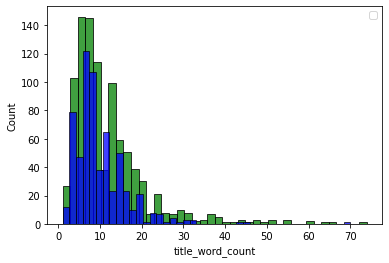

In [712]:
sns.histplot(data = tea['title_word_count'], kde = False, color = 'g')
sns.histplot(data = coffee['title_word_count'], kde = False, color ='b')
plt.legend()

There are more tea posts (green) left after cleaning compared to coffee posts (blue), which is reflected in the generally higher bars in the tea histogram.  

Text(0.5, 1.0, 'title word count for coffee')

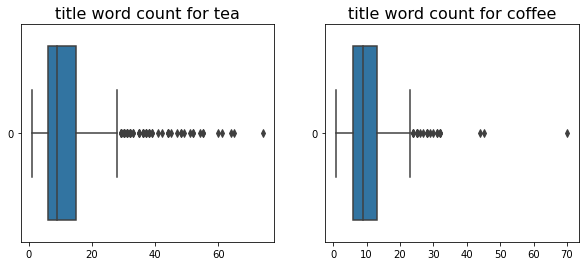

In [713]:
#visualising range of word count for title

plt.figure(figsize=(10,4))
plt.tight_layout()

plt.subplot(1,2,1)
sns.boxplot(data=tea['title_word_count'], orient='h').set_title(
    'title word count for tea',fontsize=16)
#plt.setp(ax[0][1].get_xticklabels(), fontsize=14);

plt.subplot(1,2,2)
sns.boxplot(data=coffee['title_word_count'], orient='h').set_title(
    'title word count for coffee',fontsize=16)
#plt.setp(ax[1][0].get_xticklabels(), fontsize=14);


Title word count fall within similar range for tea and coffee posts.

#### Create self text word count column

In [714]:
tea['selftext_word_count'] = tea['selftext_cleaned'].str.split(" ").map(len)
coffee['selftext_word_count'] = coffee['selftext_cleaned'].str.split(" ").map(len)

C:\Users\yongl\AppData\Local\Temp/ipykernel_34828/676897181.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tea['selftext_word_count'] = tea['selftext_cleaned'].str.split(" ").map(len)
C:\Users\yongl\AppData\Local\Temp/ipykernel_34828/676897181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coffee['selftext_word_count'] = coffee['selftext_cleaned'].str.split(" ").map(len)


In [715]:
tea['selftext_word_count'].describe() 

count    950.000000
mean      44.865263
std       84.646633
min        2.000000
25%        2.000000
50%        2.000000
75%       64.000000
max      939.000000
Name: selftext_word_count, dtype: float64

In [716]:
coffee['selftext_word_count'].describe()

count     628.000000
mean      173.221338
std       215.442959
min         2.000000
25%        78.000000
50%       125.000000
75%       204.250000
max      4131.000000
Name: selftext_word_count, dtype: float64

Text(0.5, 1.0, 'self text word count for coffee')

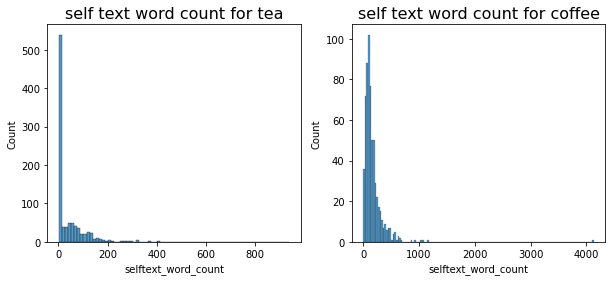

In [717]:
#visualising distribution of word count for self text

plt.figure(figsize=(10,4))
plt.tight_layout()

plt.subplot(1,2,1)
sns.histplot(data = tea['selftext_word_count'], kde = False).set_title(
    'self text word count for tea',fontsize=16)

plt.subplot(1,2,2)
sns.histplot(data = coffee['selftext_word_count'], kde = False).set_title(
    'self text word count for coffee',fontsize=16)

Self text for Coffee posts tend to be longer. The mean self text length for tea is about 45 words, while that for coffee is about 173.

Text(0.5, 1.0, 'self text word count for coffee')

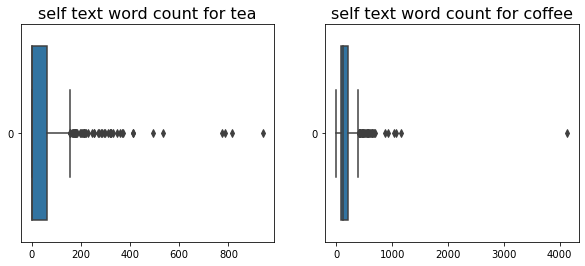

In [718]:
#visualising range of word count for self text

plt.figure(figsize=(10,4))
plt.tight_layout()

plt.subplot(1,2,1)
sns.boxplot(data=tea['selftext_word_count'], orient='h').set_title(
    'self text word count for tea',fontsize=16)
#plt.setp(ax[0][1].get_xticklabels(), fontsize=14);

plt.subplot(1,2,2)
sns.boxplot(data=coffee['selftext_word_count'], orient='h').set_title(
    'self text word count for coffee',fontsize=16)
#plt.setp(ax[1][0].get_xticklabels(), fontsize=14);


#### Examining long posts

There are self text posts which are extremely long compared to others. 

In [719]:
#there is one extremely long coffee post based on the boxplot 
print(f"Length of longest coffee post: {coffee['selftext_word_count'].max()}") #4131

Length of longest coffee post: 4131


In [720]:
print(f"Number of tea posts longer than 600 words: {(tea['selftext_word_count']>600).sum()}") #using 600 words as an arbitrary marker for long tea posts based on boxplot 

Number of tea posts longer than 600 words: 4


In [721]:
#checking the very long coffee post
coffee[coffee['selftext_word_count'] == 4131]['alltext_cleaned']

514    i added wifi to my bonavita kettle  github link   \n\nq   why not just buy a coffee maker with a timer  \n\na   aww  aren t you just so cute  \n\n\nthis morning when  i picked up my phone and began browsing reddit while the drowsiness wore off  after   minutes on my phone  my white noise generator shut off  knowing i was actually getting trying to wake up     minutes later  the blinds in my ro...
Name: alltext_cleaned, dtype: object

In [722]:
#checking the very long tea posts
tea[tea['selftext_word_count']>600][['selftext_cleaned']]

,selftext_cleaned
173,hey guys discovering reddit and the tea world in it i was surprised that some of the people who drink tea bags are sure that by choosing a good promoted brand they are into in the tea they are drinking and fully understand what it is about i do not want to offend consumers of tea bags just want to maybe open their eyes to the undeniable benefits of loose leaf or pressed tea which a ...
275,i’ve been a part of this sub for quite a while two things i see posted again and again are “where can i buy real yixing ” and “is this pot i got second hand real yixing” \n\nthis post is an attempt to answer both of those as well clarify a lot of misconception about the craft in general i spend most of my day authenticating and translating teapot seals and every summer i visit not recently...
477,there is so much information about the most famous chinese tea west lake long jing tea online that you may feel overwhelmed and clueless to buy one small batch to try as a long jing tea producer and vendor i’ve got a few tips to share if you want to make sure the long jing tea you buy online is authentic hope it will be helpful to you \n\n two major longjing varieties \n\n \n\n t...
771,this may bore some of you to death but for others this might be quite interesting we had some of our teas sent to element in oregon and had them prepare an analytics report for us regarding the caffeine content of some of our brewed teas \n\nwe tested multiple teas at different brewing conditions one is with our recommended brewing instructions and one is with boiling water see the ...


These posts look genuine, and with no further information available on the context, we will just keep these long posts.

## EDA on word counts

#### Top 15 single words for tea posts

In [723]:
#function to generate a dataframe of words
def generate_counts(df, col_name, num_words):
    count_vect = CountVectorizer(ngram_range = (num_words, num_words), stop_words='english', min_df=3) # Create an instance of CountVectorizer and pass in the clean_text function as the analyzer parameter
    X_counts = count_vect.fit_transform(df[col_name]) # X_counts stores the vectorized version of the data
    return pd.DataFrame(X_counts.todense(), columns = count_vect.get_feature_names()) #transforms spare array to a df

In [724]:
#create dataframe of words for tea posts
tea_counts_df = generate_counts(tea, 'alltext_cleaned', 1)

tea_counts_df.head()

,able,absolutely,acceptable,access,accessories,according,actual,actually,adagio,add,...,yesterday,yi,yin,yixing,yorkshire,young,ys,yunnan,yuuki,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


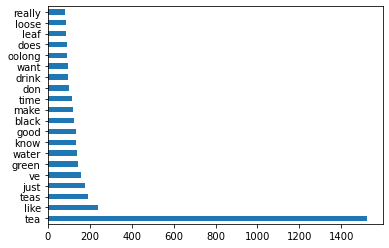

In [725]:
#top 15 most common words for tea
tea_counts_df.sum().sort_values(ascending = False).head(20).plot(kind='barh');

#### Top 15 single words for coffee posts

In [726]:
#create dataframe of words for coffee posts
coffee_counts_df = generate_counts(coffee, 'alltext_cleaned', 1)

coffee_counts_df.head()

,ability,able,absolute,absolutely,access,accident,accidentally,according,accuracy,accurate,...,year,years,yes,yesterday,yield,yields,yirgacheffe,youtube,zero,zpresso
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


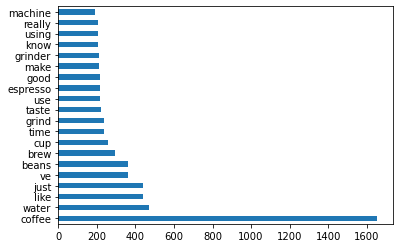

In [727]:
#top 15 most common words for coffee
coffee_counts_df.sum().sort_values(ascending = False).head(20).plot(kind='barh');

In [728]:
tea_words = (tea_counts_df.sum().sort_values(ascending = False).head(20)).index.tolist()
coffee_words = (coffee_counts_df.sum().sort_values(ascending = False).head(20)).index.tolist()

print(f'Top 20 tea words: {tea_words}\n')
print(f'Top 20 coffee words: {coffee_words}\n')

Top 20 tea words: ['tea', 'like', 'teas', 'just', 've', 'green', 'water', 'know', 'good', 'black', 'make', 'time', 'don', 'drink', 'want', 'oolong', 'does', 'leaf', 'loose', 'really']

Top 20 coffee words: ['coffee', 'water', 'like', 'just', 've', 'beans', 'brew', 'cup', 'time', 'grind', 'taste', 'use', 'espresso', 'good', 'make', 'grinder', 'know', 'using', 'really', 'machine']



## Curate additional stopwords

Looking at the top 15 words, we can add some words which we can expect based on our experience in the domain, to be highly correlated to its subreddit topic. We will also remove words that are present within both word lists. 
1. For tea:
* 'tea', 'teas', 'know', 'don', 'drink', 'want', 'does'
2. For coffee:
* 'coffee', 'taste', 'use', 'using'
3. Common words between the 2 lists:
* 'like', 'just', 've', 'water', 'know', 'good', 'make', 'time', 'really'

As we will later be using the stopwords from the nltk corpus of stopwords for English language, we will check if our additional list of stopwords overlap with the nltk stopwords, and remove the overlaps from our list.

In [729]:
own_stopwords = ['tea', 'teas', 'know', 'don', 'drink', 'want', 'does', 'coffee', 'taste', 'use', 
                 'using', 'like', 'just', 've', 'water', 'know', 'good', 'make', 'time', 'really' ]

#check for overlap of words between the 2 own_stopwords and nltk stopwords
print(f"Overlap in stopwords with nltk corpus: {[x for x in own_stopwords if x in nltk.corpus.stopwords.words('english')]}")

#remove overlap words with ntlk stopword
add_stopword = [x for x in own_stopwords if x not in nltk.corpus.stopwords.words('english')]
print(f"Number of additional stopwords after removing overlap: {len(add_stopword)}")

Overlap in stopwords with nltk corpus: ['don', 'does', 'just', 've']
Number of additional stopwords after removing overlap: 16


The additional stopwords will be added to the nltk stopwords at the stopwords removal stage later.

#### Top 15 bigrams for tea posts

In [730]:
tea_bigram_df = generate_counts(tea, 'alltext_cleaned', 2)
tea_bigram_df.sum().sort_values(ascending = False).head(15)

green tea     92
black tea     77
loose leaf    59
white tea     48
long jing     43
tea bags      37
tea leaves    34
leaf tea      28
iced tea      28
earl grey     26
don know      24
make tea      24
new tea       22
does know     19
ve tried      18
dtype: int64

#### Top 15 bigrams for coffee posts

In [731]:
coffee_bigram_df = generate_counts(coffee, 'alltext_cleaned', 2)
coffee_bigram_df.sum().sort_values(ascending = False).head(15)

french press        106
cold brew            71
moka pot             67
espresso machine     42
grind size           41
coffee beans         37
don know             36
cup coffee           36
ve tried             35
coffee just          28
brew time            28
good coffee          26
coffee water         26
coffee maker         25
coffee shop          25
dtype: int64

The most common bigrams are very different as well.

#### Top 15 trigram for tea posts

In [732]:
tea_trigram_df = generate_counts(tea, 'alltext_cleaned', 3)
tea_trigram_df.sum().sort_values(ascending = False).head(15)

loose leaf tea           23
tea ml water             15
sheng pu er               7
loose leaf teas           7
japanese green tea        7
like black tea            6
harney amp sons           5
tie guan yin              5
pu erh tea                5
loose leaf black          5
international tea day     5
bai mu dan                5
green tea black           5
earl grey tea             5
cold brew tea             5
dtype: int64

#### Top 15 trigram for coffee posts

In [733]:
coffee_trigram_df = generate_counts(coffee, 'alltext_cleaned', 3)
coffee_trigram_df.sum().sort_values(ascending = False).head(15)

pre ground coffee      8
local coffee shop      8
adjust grind size      5
coffee moka pot        5
total brew time        5
drip coffee maker      5
cup moka pot           5
zpresso jx pro         5
beans local roaster    5
coffee don know        5
coffee french press    5
coffee ml water        4
french press coffee    4
roast dark roast       4
bialetti moka pot      4
dtype: int64

## Tokenisation, Remove Stopwords, Lemmatisation

#### Create preprocessing functions

In [734]:
#create function to carry out tokenisation
def make_tokens(df):
    def to_tokens(s):
        # Instantiate tokenizer.
        tokenizer = RegexpTokenizer('\s+', gaps=True) #splitting our tokens up by spaces.
        # Run tokenizer. 
        return tokenizer.tokenize(s)
    #original_cols = ['title', 'selftext', 'alltext'] #defined earlier
    cleaned_cols = ['title_cleaned', 'selftext_cleaned', 'alltext_cleaned']
    for col in cleaned_cols:
        tokenized_col_name = str(col).replace('_cleaned', '_token')# + '_tokens'
        df[tokenized_col_name] = df[col].apply(lambda x: to_tokens(x))
    return df

#create function to remove stopwords
def drop_stopwords(df):
    def remove_stopwords(tokenized_list):
        stopword = nltk.corpus.stopwords.words('english') + add_stopword
        # Store in text only if word is not found in stopword i.e. it is not a stopword
        text = [word for word in tokenized_list if word not in stopword]
        return text

    tokenised_cols = ['title_token', 'selftext_token', 'alltext_token']
    for col in tokenised_cols:
        sw_col_name = str(col).replace('_token', '_sw') #+ '_sw'
        df[sw_col_name] = df[col].apply(lambda x: remove_stopwords(x))
    return df

#create function for lemmatisation
def lemmatise(df):
    def to_lem(tokenized_sw_list):
        # Instantiate lemmatizer.
        lemmatizer = WordNetLemmatizer()
        # Lemmatize tokenised list
        return [lemmatizer.lemmatize(i) for i in tokenized_sw_list] 
    
    tokenised_sw_cols = ['title_sw', 'selftext_sw', 'alltext_sw']
    for col in tokenised_sw_cols:
        lem_name = str(col).replace('_sw', '_lem') #+ '_lem'
        df[lem_name] = df[col].apply(lambda x: to_lem(x))
    return df

#consolidate all preprocessing processes in one function
def preprocessing(df):
    make_tokens(df)
    drop_stopwords(df)
    lemmatise(df)
    return df

In [735]:
# carry out preprocessing steps on tea and coffee
preprocessing(tea)
preprocessing(coffee)

C:\Users\yongl\AppData\Local\Temp/ipykernel_34828/3023615851.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[tokenized_col_name] = df[col].apply(lambda x: to_tokens(x))
C:\Users\yongl\AppData\Local\Temp/ipykernel_34828/3023615851.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sw_col_name] = df[col].apply(lambda x: remove_stopwords(x))
C:\Users\yongl\AppData\Local\Temp/ipykernel_34828/3023615851.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

,subreddit,title,selftext,alltext,title_cleaned,selftext_cleaned,alltext_cleaned,title_word_count,selftext_word_count,title_token,selftext_token,alltext_token,title_sw,selftext_sw,alltext_sw,title_lem,selftext_lem,alltext_lem
0,Coffee,[MOD] The Daily Question Thread,"\n\nWelcome to the daily [/r/Coffee](https://www.reddit.com/r/Coffee) question thread!\n\nThere are no stupid questions here, ask a question and get an answer! We all have to start somewhere and sometimes it is hard to figure out just what you are doing right or doing wrong. Luckily, the [/r/Coffee](https://www.reddit.com/r/Coffee) community loves to help out.\n\nDo you have a question about ...","[MOD] The Daily Question Thread \n\nWelcome to the daily [/r/Coffee](https://www.reddit.com/r/Coffee) question thread!\n\nThere are no stupid questions here, ask a question and get an answer! We all have to start somewhere and sometimes it is hard to figure out just what you are doing right or doing wrong. Luckily, the [/r/Coffee](https://www.reddit.com/r/Coffee) community loves to help out.\...",mod the daily question thread,\n\nwelcome to the daily r coffee question thread \n\nthere are no stupid questions here ask a question and get an answer we all have to start somewhere and sometimes it is hard to figure out just what you are doing right or doing wrong luckily the r coffee community loves to help out \n\ndo you have a question about how to use a specific piece of gear or what gear you should be...,mod the daily question thread \n\nwelcome to the daily r coffee question thread \n\nthere are no stupid questions here ask a question and get an answer we all have to start somewhere and sometimes it is hard to figure out just what you are doing right or doing wrong luckily the r coffee community loves to help out \n\ndo you have a question about how to use a specific piece of...,7,199,"[mod, the, daily, question, thread]","[welcome, to, the, daily, r, coffee, question, thread, there, are, no, stupid, questions, here, ask, a, question, and, get, an, answer, we, all, have, to, start, somewhere, and, sometimes, it, is, hard, to, figure, out, just, what, you, are, doing, right, or, doing, wrong, luckily, the, r, coffee, community, loves, to, help, out, do, you, have, a, question, about, how, to, use, a, specific, pi...","[mod, the, daily, question, thread, welcome, to, the, daily, r, coffee, question, thread, there, are, no, stupid, questions, here, ask, a, question, and, get, an, answer, we, all, have, to, start, somewhere, and, sometimes, it, is, hard, to, figure, out, just, what, you, are, doing, right, or, doing, wrong, luckily, the, r, coffee, community, loves, to, help, out, do, you, have, a, question, a...","[mod, daily, question, thread]","[welcome, daily, r, question, thread, stupid, questions, ask, question, get, answer, start, somewhere, sometimes, hard, figure, right, wrong, luckily, r, community, loves, help, question, specific, piece, gear, gear, buying, much, grind, sure, much, hot, wondering, shelf, life, forget, resources, wiki, great, starter, guides, wiki, guides, page, wiki, gear, price, page, see, gear, r, members, ...","[mod, daily, question, thread, welcome, daily, r, question, thread, stupid, questions, ask, question, get, answer, start, somewhere, sometimes, hard, figure, right, wrong, luckily, r, community, loves, help, question, specific, piece, gear, gear, buying, much, grind, sure, much, hot, wondering, shelf, life, forget, resources, wiki, great, starter, guides, wiki, guides, page, wiki, gear, price,...","[mod, daily, question, thread]","[welcome, daily, r, question, thread, stupid, question, ask, question, get, answer, start, somewhere, sometimes, hard, figure, right, wrong, luckily, r, community, love, help, question, specific, piece, gear, gear, buying, much, grind, sure, much, hot, wondering, shelf, life, forget, resource, wiki, great, starter, guide, wiki, guide, page, wiki, gear, price, page, see, gear, r, member, recomm...","[mod, daily,

## Merge tea and coffee to single dataframe

In [736]:
#checking shape of dfs to be merged
print(f"Shape of cleaned tea dataframe: {tea.shape}") #(950, 18)
print(f"Shape of cleaned coffee dataframe: {coffee.shape}") #(628, 18)

merged  = pd.concat([tea, coffee], axis = 0, ignore_index=True) 
print(f"Shape of merged dataframe: {merged.shape}") #(1578, 18)

Shape of cleaned tea dataframe: (950, 18)
Shape of cleaned coffee dataframe: (628, 18)
Shape of merged dataframe: (1578, 18)


## Dummify subreddit target variable

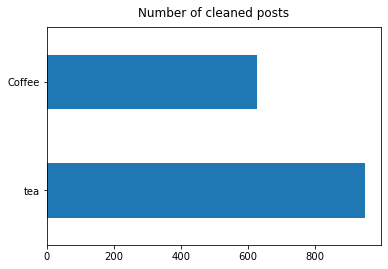

In [738]:
merged['subreddit'].value_counts().plot(kind = 'barh', yticks=merged.index)
plt.title("Number of cleaned posts", y=1.02);

In [684]:
#dummify subreddit column: 1 for tea, 0 for coffee
def is_tea(x):
    if x == 'tea':
        return 1
    elif x == 'Coffee':
        return 0

merged['subreddit'] = merged['subreddit'].apply(lambda x: is_tea(x))
merged['subreddit'].value_counts()#checking results of merging

1    950
0    628
Name: subreddit, dtype: int64

## Export combined dataframe to csv

In [685]:
merged.to_csv('data/merged.csv')

End of notebook on Data Cleaning and Preprocessing